In [5]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

# Def: Read STL 10 images
def read_STL10_data():
    # read all of the data (STL 10) https://github.com/mttk/STL10
    def read_all_images(path_to_data):
        """
        :param path_to_data: the file containing the binary images from the STL-10 dataset
        :return: an array containing all the images
        """

        with open(path_to_data, 'rb') as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)

            # We force the data into 3x96x96 chunks, since the
            # images are stored in "column-major order", meaning
            # that "the first 96*96 values are the red channel,
            # the next 96*96 are green, and the last are blue."
            # The -1 is since the size of the pictures depends
            # on the input file, and this way numpy determines
            # the size on its own.

            images = np.reshape(everything, (-1, 3, 96, 96))

            # Now transpose the images into a standard image format
            # readable by, for example, matplotlib.imshow
            # You might want to comment this line or reverse the shuffle
            # if you will use a learning algorithm like CNN, since they like
            # their channels separated.
            images = np.transpose(images, (0, 3, 2, 1))
            return images
    def read_labels(path_to_labels):
        """
        :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
        :return: an array containing the labels
        """
        with open(path_to_labels, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8)
            return labels
    def show_images(data,row=1,col=1):
        fig=plt.figure(figsize=(10,10))
        columns = col; rows = row
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(data[i-1])
        plt.show()

    train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
    train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
    test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
    test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

    label_encoder= OneHotEncoder(sparse=False,categories='auto')
    train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
    test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

    print(train_images.shape,train_images.max(),train_images.min())
    print(train_labels.shape,train_labels.max(),train_labels.min())
    print(test_images.shape,test_images.max(),test_images.min())
    print(test_labels.shape,test_labels.max(),test_labels.min())
    return train_images,train_labels,test_images,test_labels

# Def: Read CIFAR 10 images
def read_CIFAR10_data():
    # ====== miscellaneous =====
    # code from: https://github.com/tensorflow/tensorflow/issues/8246
    def tf_repeat(tensor, repeats):
        """
        Args:

        input: A Tensor. 1-D or higher.
        repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input

        Returns:

        A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
        """
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
        return repeated_tesnor
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    # ====== miscellaneous =====

    # data
    PathDicom = "../../../Dataset/cifar-10-batches-py/"
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if not ".html" in filename.lower() and not  ".meta" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    # Read the data traind and Test
    batch0 = unpickle(lstFilesDCM[0])
    batch1 = unpickle(lstFilesDCM[1])
    batch2 = unpickle(lstFilesDCM[2])
    batch3 = unpickle(lstFilesDCM[3])
    batch4 = unpickle(lstFilesDCM[4])

    onehot_encoder = OneHotEncoder(sparse=True)
    train_batch = np.vstack((batch0[b'data'],batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data']))
    train_label = np.expand_dims(np.hstack((batch0[b'labels'],batch1[b'labels'],batch2[b'labels'],batch3[b'labels'],batch4[b'labels'])).T,axis=1).astype(np.float64)
    train_label = onehot_encoder.fit_transform(train_label).toarray().astype(np.float64)

    test_batch = unpickle(lstFilesDCM[5])[b'data']
    test_label = np.expand_dims(np.array(unpickle(lstFilesDCM[5])[b'labels']),axis=0).T.astype(np.float64)
    test_label = onehot_encoder.fit_transform(test_label).toarray().astype(np.float64)

    # reshape data
    train_batch = np.reshape(train_batch,(len(train_batch),3,32,32)); test_batch = np.reshape(test_batch,(len(test_batch),3,32,32))
    # rotate data
    train_batch = np.rot90(np.rot90(train_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64); test_batch = np.rot90(np.rot90(test_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64)
    # normalize
    train_batch= train_batch/255.0; test_batch = test_batch/255.0

    # print out the data shape and the max and min value
    print(train_batch.shape,train_batch.max(),train_batch.min())
    print(train_label.shape,train_label.max(),train_label.min())
    print(test_batch.shape,test_batch.max(),test_batch.min())
    print(test_label.shape,test_label.max(),test_label.min())
    return train_batch,train_label,test_batch,test_label

<IPython.core.display.Javascript object>

(50000, 32, 32, 3) 1.0 0.0
(50000, 10) 1.0 0.0
(10000, 32, 32, 3) 1.0 0.0
(10000, 10) 1.0 0.0


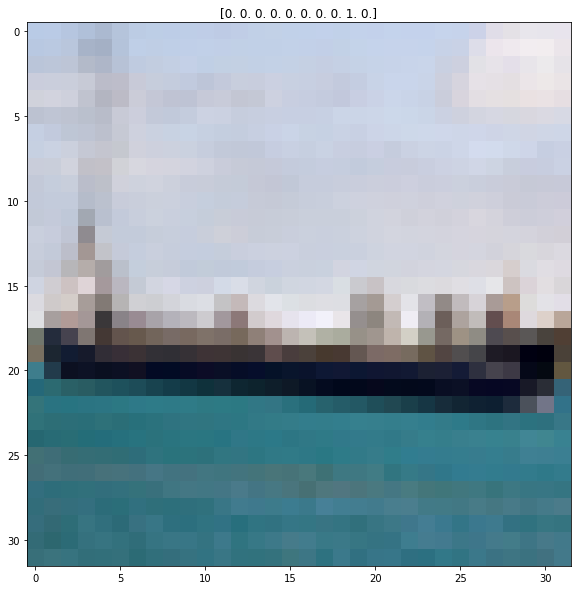

In [84]:
# read the data
train_images,train_labels,test_images,test_labels = read_CIFAR10_data()
rand_choice = np.random.choice(len(train_images))
plt.figure(figsize=(10,10))
plt.imshow(train_images[rand_choice])
plt.title(str(train_labels[rand_choice]))
plt.show()

In [86]:
# define learning rate
num_eps   = 10; num_epoch = 200; learning_rate = 0.0008; batch_size = 50;  beta1,beta2,adam_e = 0.9,0.999,1e-9; print_iter = 100

In [79]:
# create the layers
def tf_softmax(x):    return tf.nn.softmax(x)
def tf_relu(x):       return tf.nn.relu(x)
def d_tf_relu(x):     return tf.cast(tf.greater(x,0),tf.float32)
def tf_iden(x):       return x
def d_tf_iden(x):     return tf.ones_like(x)
def tf_sigmoid(x):    return tf.nn.sigmoid(x)
def d_tf_sigmoid(x):  return tf_sigmoid(x) * (1.0-tf_sigmoid(x))
def tf_softplus(x):   return tf.nn.softplus(x)
def d_tf_softplus(x): return tf.nn.sigmoid(x)

class FNN():

    def __init__(self,inc,outc,act=tf_iden,d_act=d_tf_iden,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))

        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w
    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        update_w = []

        # Update the Weight First
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        return grad_pass,update_w
class CNN():

    def __init__(self,k,inc,out, stddev=0.05,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w
    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    
    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) 
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

In [80]:
# create the modules
class Encoder():
    def __init__(self):
        self.l1 = CNN(4,3, 64); 
        self.l2 = CNN(4,64,128); 
        self.l3 = CNN(4,128,256); 
        self.l4 = CNN(4,256,512); 
        self.l5 = FNN(512*20*20,64); 
        
    def feedforward(self,input):
        layer1, layer1a = self.l1. feedforward(input,stride=1)
        layer2, layer2a = self.l2. feedforward(layer1a,stride=1)
        layer3, layer3a = self.l3. feedforward(layer2a,stride=1)
        layer4, layer4a = self.l4. feedforward(layer3a,stride=1)
        layer5_input    = tf.reshape(layer4a,[batch_size,-1])
        layer5, layer5a = self.l5. feedforward(layer5_input)
        return layer5a,layer2a
    
    def backprop(self,grad):
        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient,std_value=std_value)
        grad5p,grad5w,grad5_up = l5.backprop(grad6p,std_value=std_value)
        grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2,std_value=std_value)
        grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2,std_value=std_value)
        grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2,std_value=std_value)
        grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2,std_value=std_value)
        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 
        return None 
class GlobalDiscriminator():
    
    def __init__(self):
        self.c0 = CNN(3,128,64)
        self.c1 = CNN(3,64, 32,               act=tf_iden,d_act=tf_iden)
        self.l0 = FNN(32*22*22+64,512,act=tf_relu,d_act=d_tf_relu)
        self.l1 = FNN(512, 512               ,act=tf_iden,d_act=tf_iden)
        self.l2 = FNN(512, 1)

    def feedforward(self, encoded, features):
        layer1,layer1a = self.c0.feedforward(features)
        layer2,layer2a = self.c1.feedforward(layer1a)
        
        layer2a_reshape= tf.reshape(layer2a,[batch_size,-1])
        layer3_input   = tf.concat([layer2a_reshape,encoded],axis=1)
        
        layer3,layer3a = self.l0.feedforward(layer3_input)
        layer4,layer4a = self.l1.feedforward(layer3a)
        layer5,layer5a = self.l2.feedforward(layer4a)
        return layer5a
    
    def backprop(self):
        return None
class LocalDiscriminator():
    
    def __init__(self):
        self.l1 = CNN(1,192,512); 
        self.l2 = CNN(1,512,512); 
        self.l3 = CNN(1,512,1); 
        
    def feedforward(self,input):
        layer1, layer1a = self.l1. feedforward(input,  stride=1)
        layer2, layer2a = self.l2. feedforward(layer1a,stride=1)  
        layer3, layer3a = self.l3. feedforward(layer2a,stride=1)  
        return layer3a
    
    def backprop(self):
        return None  
class PriorDiscriminator():
    
    def __init__(self):
        self.l1 = FNN(64,1000, act=tf_relu,d_act=d_tf_relu)
        self.l2 = FNN(1000,200,act=tf_relu,d_act=d_tf_relu)
        self.l3 = FNN(200,1,   act=tf_sigmoid,d_act=d_tf_sigmoid)

    def feedforward(self, x):
        layer1,layer1a = self.l1.feedforward(x)
        layer2,layer2a = self.l2.feedforward(layer1a)
        layer3,layer3a = self.l3.feedforward(layer2a)
        return layer3a
    
    def backprop(self,grad):
        return None

In [81]:
# build encoder 
alpha = 0.5 ; beta = 1.0 ; gamma = 0.1
x = tf.placeholder(tf.float32,(batch_size,32,32,3))
y = tf.placeholder(tf.float32,(batch_size,10))

# 0. create models
MI_encoder = Encoder()
Global_Dis = GlobalDiscriminator()
Local_Dis  = LocalDiscriminator()
Prior_Dis  = PriorDiscriminator()

# 1. generate encoding
encoded,features = MI_encoder.feedforward(x)

# 2. create prime variables
features_prime = tf.transpose(features,[0,2,1,3])
encoded_expand = tf.tile(encoded[:,None,None,:],[1,26,26,1])
encoded_M        = tf.concat([features,encoded_expand],3)
encoded_M_prime  = tf.concat([features_prime,encoded_expand],3)

# 3. global loss
Ej  = -tf.reduce_mean(tf_softplus(-Global_Dis.feedforward(encoded,features)))
Em  = tf.reduce_mean(tf_softplus (Global_Dis.feedforward(encoded,features_prime)))
GLOBAL_LOSS = (Em - Ej) * alpha 

# 4.local loss
Ej  = -tf.reduce_mean(tf_softplus(-Local_Dis.feedforward(encoded_M)))
Em  = tf.reduce_mean(tf_softplus (Local_Dis.feedforward(encoded_M_prime)))
LOCAL_LOSS = (Em - Ej) * beta 

# 5. Prior
prior = tf.random_uniform(tf.shape(encoded))
term_a= tf.reduce_mean(tf.log(Prior_Dis.feedforward(prior)))
term_b= tf.reduce_mean(tf.log(1.0 - Prior_Dis.feedforward(encoded)))
PRIOR = - (term_a + term_b) * gamma

TOTAL_LOSS = GLOBAL_LOSS + LOCAL_LOSS + PRIOR

In [87]:
# loop
for epoch in range(1):

    # train_batch,train_label = shuffle(train_batch,train_label)

    for batch_size_index in range(0,len(train_images),batch_size):
        current_batch       = train_images[batch_size_index:batch_size_index+batch_size]
        current_batch_label = train_labels[batch_size_index:batch_size_index+batch_size]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

In [ ]:
# import lib
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn as nn

import torch
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import statistics as stats
import argparse

In [30]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(3, 64, kernel_size=4, stride=1)
        self.c1 = nn.Conv2d(64, 128, kernel_size=4, stride=1)
        self.c2 = nn.Conv2d(128, 256, kernel_size=4, stride=1)
        self.c3 = nn.Conv2d(256, 512, kernel_size=4, stride=1)
        self.l1 = nn.Linear(512*20*20, 64)

        self.b1 = nn.BatchNorm2d(128)
        self.b2 = nn.BatchNorm2d(256)
        self.b3 = nn.BatchNorm2d(512)

    def forward(self, x):
        h = F.relu(self.c0(x))                      # (64, 64, 29, 29)
        features = F.relu(self.b1(self.c1(h)))      # (64, 128, 26, 26)
        h = F.relu(self.b2(self.c2(features)))      # (64, 256, 23, 23)
        h = F.relu(self.b3(self.c3(h)))             # (64, 512, 20, 20)
        encoded = self.l1(h.view(x.shape[0], -1))   # (batch,64)
        return encoded, features  
class GlobalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(128, 64, kernel_size=3) # (64, 64, 24, 24)
        self.c1 = nn.Conv2d(64, 32,  kernel_size=3)  # (64, 32, 22, 22)
        self.l0 = nn.Linear(32 * 22 * 22 + 64, 512) # (64, 512)
        self.l1 = nn.Linear(512, 512)               # (512, 512)
        self.l2 = nn.Linear(512, 1)                 # (512, 1)

    def forward(self, y, M):
        h = F.relu(self.c0(M))
        h = self.c1(h)
        h = h.view(y.shape[0], -1)
        h = torch.cat((y, h), dim=1)
        h = F.relu(self.l0(h))
        h = F.relu(self.l1(h))
        return self.l2(h)  
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(192, 512, kernel_size=1)
        self.c1 = nn.Conv2d(512, 512, kernel_size=1)
        self.c2 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        return self.c2(h)  
class PriorDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(64, 1000)
        self.l1 = nn.Linear(1000, 200)
        self.l2 = nn.Linear(200, 1)

    def forward(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return torch.sigmoid(self.l2(h))
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(64, 15)
        self.bn1 = nn.BatchNorm1d(15)
        self.l2 = nn.Linear(15, 10)
        self.bn2 = nn.BatchNorm1d(10)
        self.l3 = nn.Linear(10, 10)
        self.bn3 = nn.BatchNorm1d(10)

    def forward(self, x):
        encoded, _ = x[0], x[1]
        clazz = F.relu(self.bn1(self.l1(encoded)))
        clazz = F.relu(self.bn2(self.l2(clazz)))
        clazz = F.softmax(self.bn3(self.l3(clazz)), dim=1)
        return clazz
class DeepInfoMaxLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=1.0, gamma=0.1):
        super().__init__()
        self.global_d = GlobalDiscriminator()
        self.local_d = LocalDiscriminator()
        self.prior_d = PriorDiscriminator()
        self.alpha   = alpha
        self.beta    = beta
        self.gamma   = gamma

    def forward(self, y, M, M_prime):

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        
        # CREATE
        y_exp = y.unsqueeze(-1).unsqueeze(-1)
        y_exp = y_exp.expand(-1, -1, 26, 26)
        y_M = torch.cat((M, y_exp), dim=1)
        y_M_prime = torch.cat((M_prime, y_exp), dim=1)

        # Local          
        Ej = -F.softplus(-self.local_d(y_M)).mean()
        Em = F.softplus(self.local_d(y_M_prime)).mean()
        LOCAL = (Em - Ej) * self.beta
       
        # Global         
        Ej = -F.softplus(-self.global_d(y, M)).mean()
        Em = F.softplus(self.global_d(y, M_prime)).mean()
        GLOBAL = (Em - Ej) * self.alpha
        
        # Prior
        prior = torch.rand_like(y)
        term_a = torch.log(self.prior_d(prior)).mean()
        term_b = torch.log(1.0 - self.prior_d(y)).mean()
        PRIOR = - (term_a + term_b) * self.gamma

        return LOCAL + GLOBAL + PRIOR
class DeepInfoAsLatent(nn.Module):
    def __init__(self, run, epoch):
        super().__init__()
        model_path = Path(r'c:/data/deepinfomax/models') / Path(str(run)) / Path('encoder' + str(epoch) + '.wgt')
        self.encoder = Encoder()
        self.encoder.load_state_dict(torch.load(str(model_path)))
        self.classifier = Classifier()

    def forward(self, x):
        z, features = self.encoder(x)
        z = z.detach()
        return self.classifier((z, features))
# device = torch.device('cpu')
batch_size = 64

# image size 3, 32, 32 batch size must be an even numbershuffle must be True
cifar_10_train_dt = CIFAR10(r'c:\data\tv',  download=True, transform=ToTensor())
cifar_10_train_l  = DataLoader(cifar_10_train_dt, batch_size=batch_size, shuffle=True, drop_last=True,pin_memory=torch.cuda.is_available())

encoder    = Encoder().to(device)
loss_fn    = DeepInfoMaxLoss().to(device)
optim      = Adam(encoder.parameters(), lr=1e-4)
loss_optim = Adam(loss_fn.parameters(), lr=1e-4)

for epoch in range(100):
    batch = tqdm(cifar_10_train_l, total=len(cifar_10_train_dt) // batch_size)
    train_loss = []
    
    for x, target in batch:
        x = x.to(device)

        optim.zero_grad(); loss_optim.zero_grad()
        y, M = encoder(x)
        # y - > (64, 128, 26, 26)
        # M - > (batch,64)
        
        # rotate images to create pairs for comparison (ROTATING)
        M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
        loss = loss_fn(y, M, M_prime) # ()
        sys.exit()
        
        train_loss.append(loss.item())
        batch.set_description(str(epoch) + ' Loss: ' + str(stats.mean(train_loss[-20:])))
        loss.backward()
        optim.step(); loss_optim.step()


Files already downloaded and verified



  0%|                                                                                                | 0/781 [00:00<?, ?it/s]

torch.Size([64, 64, 1, 1])
torch.Size([64, 64, 26, 26])
torch.Size([64, 192, 26, 26])
torch.Size([64, 192, 26, 26])
torch.Size([])
torch.Size([])
torch.Size([])


SystemExit: 

In [ ]:
# batch = tqdm(cifar_10_train_l, total=len(cifar_10_train_dt) // batch_size)
for x, target in batch:
    temp = np.swapaxes(np.swapaxes(x.numpy(),1,3),2,1)
    plt.imshow(temp[0])
    plt.show()
    print(temp.shape)
    print(target.numpy().shape)
    sys.exit()